In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
import os
import tensorflow as tf
import datetime


df = pd.read_csv('NVDA_train.csv')
df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']]
df.index = df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')

In [47]:
# plt.figure(figsize=(10, 6))
# plt.plot(train_df['Date'], train_df['Close'], marker='', linestyle='-')
# plt.title('Training Data: Close Values Over Time')
# plt.xlabel('Date')
# plt.ylabel('Close Value')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(test_df['Date'], test_df['Close'], marker='', linestyle='-')
# plt.title('Testing Data: Close Values Over Time')
# plt.xlabel('Date')
# plt.ylabel('Close Value')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# datapreprocessing for lstm

In [256]:
def generate_windowed_dataset(dataframe, start_date_str, end_date_str, window_size=3):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data['Close'].to_numpy()
        X.append(values[:-1])
        y.append(values[-1])
        dates.append(target_date)

        next_date = target_date + pd.DateOffset(days=1)

        if next_date > end_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i in range(window_size):
        ret_df[f'Target-{window_size-i}'] = np.array(X)[:, i]
    ret_df['Target'] = y

    return ret_df

# # Start day second time around: '2021-03-25'
# windowed_df = generate_windowed_dataset(df,
#                                 '2021-03-25',
#                                 '2022-03-23',
#                                 3)
# windowed_df

In [257]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)

# LSTM Baseline

## preprocessing

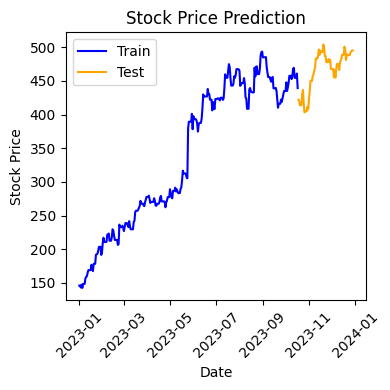

In [270]:
windowed_df = generate_windowed_dataset(df, '2023-01-01', '2023-12-29', window_size=3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [271]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

Epoch 1/100
10/10 [==============================] - 1s 33ms/step - loss: 125435.2031 - mean_absolute_error: 338.1011 - val_loss: 217320.8438 - val_mean_absolute_error: 465.2519
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 124999.7344 - mean_absolute_error: 337.4372 - val_loss: 216537.4375 - val_mean_absolute_error: 464.4092
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 124371.4922 - mean_absolute_error: 336.5146 - val_loss: 215522.5000 - val_mean_absolute_error: 463.3152
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 123526.9531 - mean_absolute_error: 335.2653 - val_loss: 214225.5156 - val_mean_absolute_error: 461.9132
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 122360.9375 - mean_absolute_error: 333.4944 - val_loss: 212005.1562 - val_mean_absolute_error: 459.5030
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 120556.9922 - mean_absolute_error: 330.74

## plotting

10/10 [==============================] - 0s 890us/step


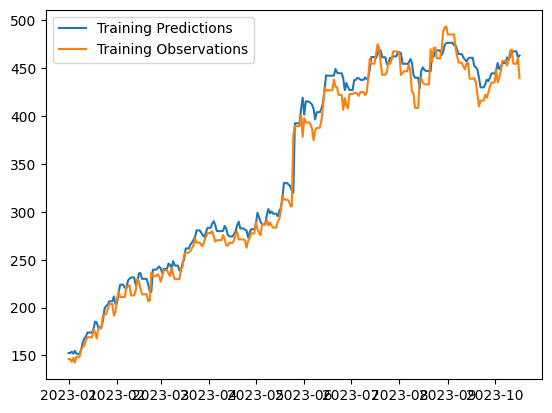

In [272]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 1ms/step


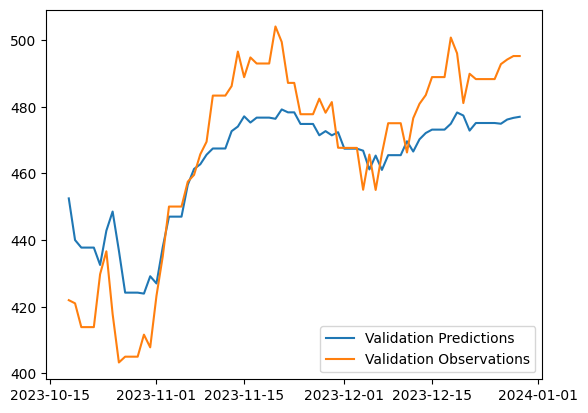

In [273]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict

## evaluating on test set

1/1 [==============================] - 0s 386ms/step - loss: 367.7047 - mean_absolute_error: 19.1756
Test Loss: 367.7047424316406
Test Mean Absolute Error: 19.175628662109375
1/1 [==============================] - 0s 213ms/step


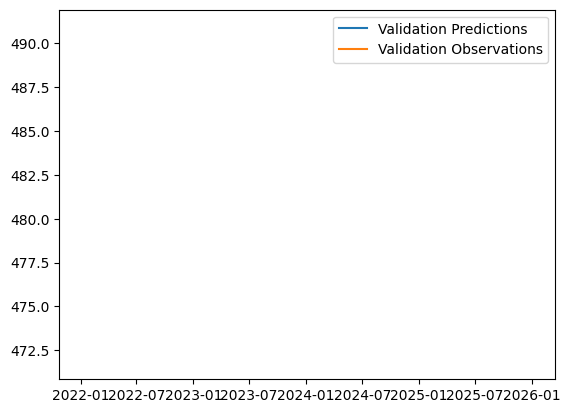

In [274]:
model = tf.keras.models.load_model('trained_models/baseline.keras')

windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2023-03-07', window_size=3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Validation Predictions', 'Validation Observations'])